In [1]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
%matplotlib inline

import tfi_exact # for later comparison

In [2]:
import a_mps
import b_model
import c_tebd

In [3]:
# (changes compared to previous definitions are marked with comments)
# adjustments for a_mps

class InfiniteMPS(a_mps.MPS):
    """Represents an uniform (infinite) MPS."""
    
    def get_theta2(self, i):
        """Calculate effective two-site wave function on sites i,j=(i+1) in mixed canonical form.

        The returned array has legs ``vL, i, j, vR``."""
        j = (i + 1) % self.L  # <- changed here
        return np.tensordot(self.get_theta1(i), self.Bs[j], [2, 0])  # vL i [vR], [vL] j vR
    
    def get_chi(self):
        """Return bond dimensions."""
        return [self.Bs[i].shape[2] for i in range(self.L)] # <- changed the argument of range(...)
    
    def bond_expectation_value(self, op):
        """Calculate expectation values of a local operator at each bond."""
        result = []
        for i in range(self.L):  # <- changed here
            theta = self.get_theta2(i)  # vL i j vR
            op_theta = np.tensordot(op[i], theta, axes=[[2, 3], [1, 2]])
            # i j [i*] [j*], vL [i] [j] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2, 3], [2, 0, 1, 3]]))
            # [vL*] [i*] [j*] [vR*], [i] [j] [vL] [vR]
        return np.real_if_close(result)
    
    def entanglement_entropy(self):
        """Return the (von-Neumann) entanglement entropy for a bipartition at any of the bonds."""
        result = []
        for i in range(1, self.L+1):  # <- changed here
            # Note: Self.Ss[i] is left of self.Bs[i], while we consider bond "i" in bond_expectation_value and for the
            # updates to be right of site i, therefore we start i with 1 and take i % L.
            S = self.Ss[i % self.L].copy()  # <- changed here
            S[S < 1.e-20] = 0.  # 0*log(0) should give 0; avoid warning or NaN.
            S2 = S * S
            assert abs(np.linalg.norm(S) - 1.) < 1.e-14
            result.append(-np.sum(S2 * np.log(S2)))
        return np.array(result)
    
def init_infinite_spinup_MPS(L=2):
    """Return a product state with all spins up as an MPS"""
    B = np.zeros([1, 2, 1], np.float)
    B[0, 0, 0] = 1.
    S = np.ones([1], np.float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return InfiniteMPS(Bs, Ss)

In [4]:
# adjustments of b_model
class InfiniteTFIModel(b_model.TFIModel):
    def init_H_bonds(self):
        """Initialize `H_bonds` hamiltonian. Called by __init__()."""
        sx, sz, id = self.sigmax, self.sigmaz, self.id
        d = self.d
        H_list = []
        for i in range(self.L): # <- changed here: up to L
            gL = gR = 0.5 * self.g
            # changed here: removed if-cases
            H_bond = -self.J * np.kron(sx, sx) - gL * np.kron(sz, id) - gR * np.kron(id, sz)
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list
        
    def energy(self, psi):
        return super().energy(psi) / self.L

In [5]:
# adjustments of c_tebd
def update_bond(psi, i, U_bond, chi_max, eps):
    """Apply `U_bond` acting on i,j=(i+1) to `psi`."""
    j = (i + 1) % psi.L  # <- changed here
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = a_mps.split_truncate_theta(Utheta, chi_max, eps)   # the original split_truncate_theta
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=[1, 0])  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=[2, 0])  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR
    
def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):
    """Evolve the state `psi` for `N_steps` time steps with (first order) TEBD.

    The state psi is modified in place."""
    Nbonds = psi.L  # <- changed
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done
    
# adjusted a bit more of this function...
def example_TEBD_gs_infinite(J, g, N_steps=500, chi_max=30):
    L = 2  # unit cell of two sites
    print("infinite TEBD (imaginary time evolution)")
    print("J={J:.1f}, g={g:.2f}".format(J=J, g=g))
    model = InfiniteTFIModel(L, J=J, g=g) # use the new defined model
    psi = init_infinite_spinup_MPS(L) # and new InfiniteMPS
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = c_tebd.calc_U_bonds(model, dt) # still the same
        run_TEBD(psi, U_bonds, N_steps=N_steps, chi_max=chi_max, eps=1.e-10)  # the new function!
        E = model.energy(psi)
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    E_exact = tfi_exact.infinite_gs_energy(1., g) # infinite instead of finite
    print("Exact (analytic): E = {E:.13f}".format(E=E_exact))
    print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, model

In [6]:
E, _, _ = example_TEBD_gs_infinite(1., 1.5, N_steps=100)

infinite TEBD (imaginary time evolution)
J=1.0, g=1.50
dt = 0.10000: E = -1.6622376659950
dt = 0.01000: E = -1.6709745193387
dt = 0.00100: E = -1.6718222587090
dt = 0.00010: E = -1.6719075837948
dt = 0.00001: E = -1.6719161221699
final bond dimensions:  [21, 21]
Exact (analytic): E = -1.6719262215362
relative error:  6.040557413640872e-06


In [7]:
E, psi, _ = example_TEBD_gs_infinite(1., 1.0, N_steps=100)  # at the critical point: larger error

infinite TEBD (imaginary time evolution)
J=1.0, g=1.00
dt = 0.10000: E = -1.2686637925848
dt = 0.01000: E = -1.2727299193540
dt = 0.00100: E = -1.2731198376954
dt = 0.00010: E = -1.2731590675618
dt = 0.00001: E = -1.2731629929455
final bond dimensions:  [30, 30]
Exact (analytic): E = -1.2732395447352
relative error:  6.012363499497619e-05


In [8]:
def eigvals_transfer_matrix(psi):
    chi = psi.Bs[0].shape[0]
    L = psi.L

    T = np.tensordot(psi.Bs[0], np.conj(psi.Bs[0]), axes=(1, 1))  # a,b,a*,b*
    T = T.transpose(0, 2, 1, 3)  # a,a*,b,b*
    for i in range(1, L):
        T = np.tensordot(T, psi.Bs[i], axes=(2, 0))  # a,a*,b*,i,b
        T = np.tensordot(T, np.conj(psi.Bs[i]), axes=([2, 3], [0,1]))  #a,a*,b,b*
    T = np.reshape(T, (chi**2, chi**2))

    # Obtain the 3 largest eigenvalues
    eigvals = scipy.sparse.linalg.eigs(T, k=3, which='LM', return_eigenvectors=False, ncv=20)
    return np.abs(eigvals)

eigvals_transfer_matrix(psi)


array([0.80996322, 0.93066836, 1.        ])

In [9]:
gs = np.linspace(0.5, 1.5, 11)
TM_eigvals = []
for g in gs:
    E, psi, mod = example_TEBD_gs_infinite(1., g, N_steps=100)
    TM_eigvals.append(eigvals_transfer_matrix(psi))

infinite TEBD (imaginary time evolution)
J=1.0, g=0.50
dt = 0.10000: E = -1.0633607863280
dt = 0.01000: E = -1.0635249098752
dt = 0.00100: E = -1.0635422497540
dt = 0.00010: E = -1.0635439872170
dt = 0.00001: E = -1.0635441609815
final bond dimensions:  [20, 20]
Exact (analytic): E = -1.0635444099734
relative error:  2.3411520705117052e-07
infinite TEBD (imaginary time evolution)
J=1.0, g=0.60
dt = 0.10000: E = -1.0918512402977
dt = 0.01000: E = -1.0921978585237
dt = 0.00100: E = -1.0922340686635
dt = 0.00010: E = -1.0922376979643
dt = 0.00001: E = -1.0922380609448
final bond dimensions:  [28, 28]
Exact (analytic): E = -1.0922385835545
relative error:  4.784757710215042e-07
infinite TEBD (imaginary time evolution)
J=1.0, g=0.70
dt = 0.10000: E = -1.1260911890582
dt = 0.01000: E = -1.1267518964978
dt = 0.00100: E = -1.1268198945470
dt = 0.00010: E = -1.1268267120569
dt = 0.00001: E = -1.1268273939305
final bond dimensions:  [30, 30]
Exact (analytic): E = -1.1268286675870
relative error:

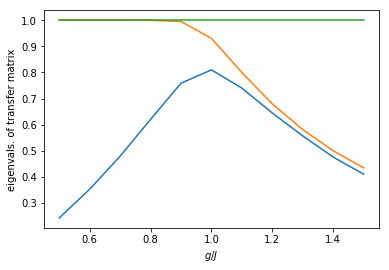

In [10]:
TM_eigvals = np.array(TM_eigvals)
plt.figure()
for i in range(3):
    plt.plot(gs, TM_eigvals[:, i])
plt.xlabel('$g/J$')
plt.ylabel('eigenvals. of transfer matrix')
plt.show()

## Interpretation
The transfermatrix appears repeatedly in expectation values $<\psi|A_i|\psi> $ and correlation functions $<\psi|A_i B_j |\psi>$. If the state is in (right) canonical form, the largest eigenvalues is 1, with $\delta_{cc'}$ as the corresponding eigenvector - the equality $T_{aa',cc'} \delta_{cc'} = \delta_{aa'}$ follows directly from the orthogonality of the B's; similarly $\Lambda_a^2 \delta_{aa'} is a left eigenvector.

For a pure state, the eigenvalue $1$ is unique, but for g < 1, $e^{-\tau H}$ yields the states $ |\rightarrow \rightarrow \dots > $ and $|\leftarrow \leftarrow \dots>$ (each + quantum fluctuations) with equal weight, i.e., not a "pure" state,
hence the degeneracy of the eigenvalue 1.

The second largest eigenvalue determines the correlation length: we can write the correlation functions as $ <A_i B_j> = L_A  T^{|j-i|/L} R_B $, where $L_A$ and $R_B$ are left and right parts of the corresponding tensor network. 
Hence, the second largest eigenvalue determines the decay of
the connected part $<A_i B_j> - <A_i> <B_j>$.
At the critical point, the correlation length diverges, which is equivalent to the second largest eigenvalues going to 1 (at least if we increase the bond dimension enough, a finite $\chi$ introduces a finite correlation length).
